In [1]:
import torch
import torchvision
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchmeta
from torchmeta.modules import (MetaModule, MetaSequential, MetaLinear)

In [2]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm
import logging

from torchmeta.utils.data import BatchMetaDataLoader
from torchmeta.utils.gradient_based import gradient_update_parameters

In [3]:
import maml_regression

**Meta-Learn landS and landS2**

In [4]:
# load landS file 
landS_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS_sample5.csv')
# split the data file 
landS_train, landS_val = train_test_split(landS_data, test_size=0.2)

# load landS2 file 
landS2_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS2_sample4.csv')
# split the data file 
landS2_train, landS2_val = train_test_split(landS2_data, test_size=0.2)

In [5]:
# pad zeros 
# 5 channels for x and 5 channels for omega 
n_x = 5
n_omega = 5

# landS

landS_train_pad_zero = np.zeros((landS_train.shape[0],n_x+n_omega+1))
landS_val_pad_zero = np.zeros((landS_val.shape[0],n_x+n_omega+1))

landS_train_pad_zero[:,:4] = landS_train.to_numpy()[:,:4]
landS_train_pad_zero[:,n_x] = landS_train.to_numpy()[:,4]
landS_train_pad_zero[:,-1] = landS_train.to_numpy()[:,-1]

landS_val_pad_zero[:,:4] = landS_val.to_numpy()[:,:4]
landS_val_pad_zero[:,n_x] = landS_val.to_numpy()[:,4]
landS_val_pad_zero[:,-1] = landS_val.to_numpy()[:,-1]

In [6]:
# landS2

landS2_train_pad_zero = np.zeros((landS2_train.shape[0],n_x+n_omega+1))
landS2_val_pad_zero = np.zeros((landS2_val.shape[0],n_x+n_omega+1))

landS2_train_pad_zero[:,:4] = landS2_train.to_numpy()[:,:4]
landS2_train_pad_zero[:,n_x : (n_x + 3)] = landS2_train.to_numpy()[:,4:7]
landS2_train_pad_zero[:,-1] = landS2_train.to_numpy()[:,-1]

landS2_val_pad_zero[:,:4] = landS2_val.to_numpy()[:,:4]
landS2_val_pad_zero[:,n_x : (n_x + 3)] = landS2_val.to_numpy()[:,4:7]
landS2_val_pad_zero[:,-1] = landS2_val.to_numpy()[:,-1]

In [7]:
# set up data loader 
batch_size = 40
nworkers = 4

landS_train_data_loader = torch.utils.data.DataLoader(landS_train_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS_val_data_loader = torch.utils.data.DataLoader(landS_val_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

landS2_train_data_loader = torch.utils.data.DataLoader(landS2_train_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS2_val_data_loader = torch.utils.data.DataLoader(landS2_val_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [8]:
 # dictionary for the data loader 
train_data_loader = {}
val_data_loader = {}

tasks = ['landS', 'landS2']
train_data_loader['landS'] = landS_train_data_loader
train_data_loader['landS2'] = landS2_train_data_loader

val_data_loader['landS'] = landS_val_data_loader
val_data_loader['landS2'] = landS2_val_data_loader

meta_data_loader = {}
meta_data_loader['train'] = train_data_loader
meta_data_loader['test'] = val_data_loader # note here test = val to follow the notation in MAML example 

In [12]:
model_parameters = {}
model_parameters['in_channels'] = n_x + n_omega
model_parameters['hidden1_size'] = 128
model_parameters['hidden2_size'] = 256
model_parameters['beta'] = 1e-3
model_parameters['alpha'] = 1e-4
model_parameters['first_order'] = False
model_parameters['num_it_outer'] = 1000
model_parameters['num_tasks'] = 2
model_parameters['output_model'] = '/Users/sonny/Documents/Courses/CSCI566/experiment2/landS_maml_model.pt'

It 0, outer traning loss: 56545.3203125
It 50, outer traning loss: 4738.41845703125
It 100, outer traning loss: 3949.91064453125
It 150, outer traning loss: 6978.26953125
It 200, outer traning loss: 3153.16552734375
It 250, outer traning loss: 7028.0771484375
It 300, outer traning loss: 1684.6031494140625
It 350, outer traning loss: 3699.10546875
It 400, outer traning loss: 1793.736572265625
It 450, outer traning loss: 1239.4794921875
It 500, outer traning loss: 416.3078308105469
It 550, outer traning loss: 165.3010711669922
It 600, outer traning loss: 859.9004516601562
It 650, outer traning loss: 156.5341796875
It 700, outer traning loss: 169.24285888671875
It 750, outer traning loss: 116.97904968261719
It 800, outer traning loss: 112.2639389038086
It 850, outer traning loss: 217.09616088867188
It 900, outer traning loss: 447.8214111328125
It 950, outer traning loss: 210.61807250976562


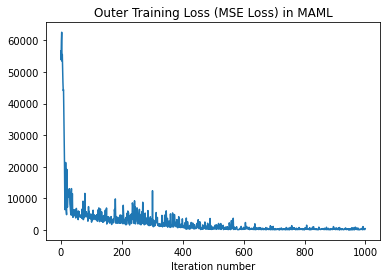

In [13]:
# run the training loop 
maml_regression.meta_train_v2(model_parameters, meta_data_loader)

**Load MAML model and fine-tune it**

In [14]:
load_path = '/Users/sonny/Documents/Courses/CSCI566/experiment2/landS_maml_model.pt'
maml_model_load = maml_regression.RegressionNeuralNetwork_v2(n_x + n_omega, hidden1_size=128, hidden2_size=256)
maml_model_load.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [15]:
# fine tune the model 
fine_tune_parameter = {}
fine_tune_parameter['learning_rate'] = 1e-4
fine_tune_parameter['Max_it'] = 600
fine_tune_parameter['epoch'] = 20
fine_tune_parameter['output_model'] = '/Users/sonny/Documents/Courses/CSCI566/experiment2/landS_maml_model_adapt.pt'

In [16]:
# load landS3 file 
landS3_data = pd.read_csv('/Users/sonny/Documents/Courses/CSCI566/experiment/training_set/landS3_sample4.csv')
# split the data file 
landS3_train, landS3_val = train_test_split(landS3_data, test_size=0.2)

In [17]:
# build data loader for landS3
batch_size = 40
nworkers = 4

landS3_train_fine_tune, landS3_other_fine_tune = train_test_split(landS3_train, test_size=0.8)


landS3_train_fine_tune_pad_zero = np.zeros((landS3_train_fine_tune.shape[0],n_x+n_omega+1))

landS3_train_fine_tune_pad_zero[:,:4] = landS3_train_fine_tune.to_numpy()[:,:4] # x
landS3_train_fine_tune_pad_zero[:,n_x:(n_x+3)] = landS3_train_fine_tune.to_numpy()[:,4:7] # omega
landS3_train_fine_tune_pad_zero[:,-1] = landS3_train_fine_tune.to_numpy()[:,-1] # h

landS3_train_fine_tune_data_loader = torch.utils.data.DataLoader(landS3_train_fine_tune_pad_zero, batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [20]:
# landS3

landS3_train_pad_zero = np.zeros((landS3_train.shape[0],n_x+n_omega+1))
landS3_val_pad_zero = np.zeros((landS3_val.shape[0],n_x+n_omega+1))

landS3_train_pad_zero[:,:4] = landS3_train.to_numpy()[:,:4]
landS3_train_pad_zero[:,n_x : (n_x + 3)] = landS3_train.to_numpy()[:,4:7]
landS3_train_pad_zero[:,-1] = landS3_train.to_numpy()[:,-1]

landS3_val_pad_zero[:,:4] = landS3_val.to_numpy()[:,:4]
landS3_val_pad_zero[:,n_x : (n_x + 3)] = landS3_val.to_numpy()[:,4:7]
landS3_val_pad_zero[:,-1] = landS3_val.to_numpy()[:,-1]

In [18]:
print(landS3_train_fine_tune.shape[0])

1600


Run Epoch 0
It 0, L2 training loss: 24206.1953125 
It 0, L2 validation loss: 24140.470703125
It 5, L2 training loss: 30460.00390625 
It 5, L2 validation loss: 23787.919921875
It 10, L2 training loss: 22236.59765625 
It 10, L2 validation loss: 23441.490234375
It 15, L2 training loss: 25088.802734375 
It 15, L2 validation loss: 23098.177734375
It 20, L2 training loss: 22376.73828125 
It 20, L2 validation loss: 22758.703125
It 25, L2 training loss: 25769.77734375 
It 25, L2 validation loss: 22422.484375
It 30, L2 training loss: 27537.927734375 
It 30, L2 validation loss: 22084.603515625
It 35, L2 training loss: 21008.71875 
It 35, L2 validation loss: 21743.1328125
Run Epoch 1
It 40, L2 training loss: 25680.80078125 
It 40, L2 validation loss: 21399.984375
It 45, L2 training loss: 23417.94921875 
It 45, L2 validation loss: 21046.0859375
It 50, L2 training loss: 18904.513671875 
It 50, L2 validation loss: 20685.349609375
It 55, L2 training loss: 21108.02734375 
It 55, L2 validation loss: 20

It 460, L2 training loss: 586.0694580078125 
It 460, L2 validation loss: 870.2927856445312
It 465, L2 training loss: 675.3055419921875 
It 465, L2 validation loss: 850.8646850585938
It 470, L2 training loss: 796.1143798828125 
It 470, L2 validation loss: 830.3057250976562
It 475, L2 training loss: 1060.8616943359375 
It 475, L2 validation loss: 809.1000366210938
Run Epoch 12
It 480, L2 training loss: 857.8692626953125 
It 480, L2 validation loss: 788.0694580078125
It 485, L2 training loss: 887.3298950195312 
It 485, L2 validation loss: 766.6327514648438
It 490, L2 training loss: 544.1353149414062 
It 490, L2 validation loss: 745.7088623046875
It 495, L2 training loss: 838.5673828125 
It 495, L2 validation loss: 724.4738159179688
It 500, L2 training loss: 789.4864501953125 
It 500, L2 validation loss: 703.7861328125
It 505, L2 training loss: 587.4241333007812 
It 505, L2 validation loss: 682.968017578125
It 510, L2 training loss: 549.2762451171875 
It 510, L2 validation loss: 662.604797

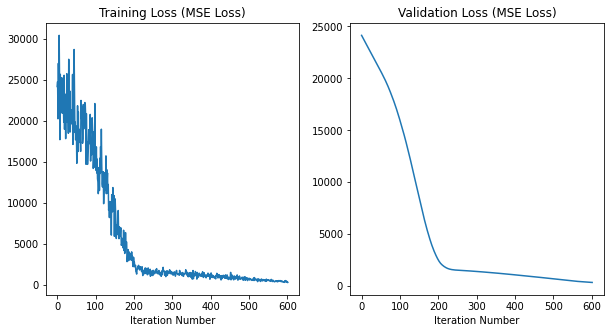

The model is saved.


In [21]:
maml_regression.fine_tune(fine_tune_parameter, maml_model_load, landS3_train_fine_tune_data_loader, landS3_val_pad_zero)

**Specialized Neural Network**

In [23]:
specialized_model = maml_regression.RegressionNeuralNetwork_v2(n_x + n_omega, hidden1_size=128, hidden2_size=256)

tune_parameter = {}
tune_parameter['learning_rate'] = 1e-4
tune_parameter['Max_it'] = 600
tune_parameter['epoch'] = 20
tune_parameter['output_model'] = None

Run Epoch 0
It 0, L2 training loss: 18361.30859375 
It 0, L2 validation loss: 21752.947265625
It 5, L2 training loss: 20610.109375 
It 5, L2 validation loss: 21706.28125
It 10, L2 training loss: 19297.916015625 
It 10, L2 validation loss: 21663.046875
It 15, L2 training loss: 20166.55859375 
It 15, L2 validation loss: 21621.634765625
It 20, L2 training loss: 28796.125 
It 20, L2 validation loss: 21579.828125
It 25, L2 training loss: 21545.45703125 
It 25, L2 validation loss: 21534.73046875
It 30, L2 training loss: 22989.28125 
It 30, L2 validation loss: 21483.34765625
It 35, L2 training loss: 23939.16796875 
It 35, L2 validation loss: 21424.65625
Run Epoch 1
It 40, L2 training loss: 20621.5234375 
It 40, L2 validation loss: 21356.552734375
It 45, L2 training loss: 20911.501953125 
It 45, L2 validation loss: 21276.830078125
It 50, L2 training loss: 20738.6171875 
It 50, L2 validation loss: 21184.70703125
It 55, L2 training loss: 27370.640625 
It 55, L2 validation loss: 21076.181640625
I

It 465, L2 training loss: 1595.2191162109375 
It 465, L2 validation loss: 2165.640869140625
It 470, L2 training loss: 1759.62890625 
It 470, L2 validation loss: 2154.12451171875
It 475, L2 training loss: 2223.02587890625 
It 475, L2 validation loss: 2145.46630859375
Run Epoch 12
It 480, L2 training loss: 2129.811279296875 
It 480, L2 validation loss: 2136.94140625
It 485, L2 training loss: 2054.173095703125 
It 485, L2 validation loss: 2125.43603515625
It 490, L2 training loss: 1987.95703125 
It 490, L2 validation loss: 2112.479248046875
It 495, L2 training loss: 2160.524658203125 
It 495, L2 validation loss: 2101.007568359375
It 500, L2 training loss: 2700.316162109375 
It 500, L2 validation loss: 2090.81689453125
It 505, L2 training loss: 2534.137451171875 
It 505, L2 validation loss: 2082.26318359375
It 510, L2 training loss: 1591.41064453125 
It 510, L2 validation loss: 2075.497802734375
It 515, L2 training loss: 1627.765380859375 
It 515, L2 validation loss: 2065.828857421875
Run 

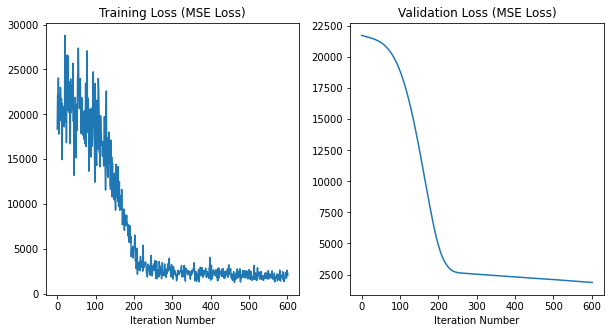

In [25]:
maml_regression.fine_tune(tune_parameter, specialized_model, landS3_train_fine_tune_data_loader, landS3_val_pad_zero)